In [1]:
from physiologycheck import *
import os
import pandas as pd
import traceback
import gc
from tqdm import tqdm

In [ ]:
from physiologycheck_1 import physiologyprocess_scene

physiologyprocess_scene(
    data_root=r"D:\Labroom\SDPhysiology\Data\Processed\RSP_Filtered",
    log_dir=r"D:\Labroom\SDPhysiology\Logs_Scene_Filtered",
    mapping_csv=r"D:\Labroom\SDPhysiology\Data\mapping.csv",
    selected_participants=None,
    figure=False,
)

[INFO] Found 2 .acq files in D:\Labroom\SDPhysiology\Data\Processed\RSP_Filtered

[1/2] Processing bhk9709_VR.acq | raw=bhk9709 → anon=098
  🎬 Scene: Practice (n=77797)
  🎬 Scene: ElevatorTest (n=156103)
  🎬 Scene: Elevator1 (n=363857)
  🎬 Scene: Outside (n=703371)
  🎬 Scene: Hallway (n=246981)
  🎬 Scene: Elevator2 (n=376760)
  🎬 Scene: Hall (n=189487)

[2/2] Processing bjs0602_VR.acq | raw=bjs0602 → anon=096
  🎬 Scene: Practice (n=77427)
  🎬 Scene: ElevatorTest (n=182405)
  🎬 Scene: Elevator1 (n=376129)
  🎬 Scene: Outside (n=1091783)
  🎬 Scene: Hallway (n=289687)
  🎬 Scene: Elevator2 (n=385855)
  🎬 Scene: Hall (n=198633)


In [3]:
BASE_PATH = r"D:/LabRoom/SDPhysiology/Data/processed_individual_anonymized"

pd.read_pickle(os.path.join(BASE_PATH, "001_Main.pkl")).filter(like="RSP").head()

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate,RSP_RVT,RSP_Phase,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs
0,0.080975,0.082357,0.211259,28.546969,0.002746,0.0,0.076923,0.585588,0.498900,0,0
1,0.069097,0.077970,0.211158,29.388115,0.002814,0.0,0.102564,0.583970,0.498540,0,0
2,0.057345,0.072560,0.211029,30.275704,0.002883,0.0,0.128205,0.582339,0.498184,0,0
3,0.045737,0.066231,0.210874,31.212424,0.002952,0.0,0.153846,0.580697,0.497831,0,0
4,0.034292,0.059092,0.210693,32.201098,0.003021,0.0,0.179487,0.579043,0.497482,0,0


In [7]:
# -*- coding: utf-8 -*-
"""
RSP 품질/이상 진단 + 윈도 요약표 생성 (A1~A4 공통 캐시)
- 입력: processed_individual_anonymized/{PID}_Main.pkl (120Hz 통합 DF)
- 출력: ml_processed_all/window_summaries.parquet (scene 포함)
"""

import os
import gc
import traceback

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import find_peaks

# =========================
# 경로/파라미터 설정
# =========================
BASE_PATH = r"D:/LabRoom/SDPhysiology/Data/processed_individual_anonymized"
OUT_DIR   = r"./ml_processed_all"
LOG_DIR   = r"./logs"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

SAMPLING_RATE  = 120  # Hz
WINDOW_SECONDS = 5
STRIDE_SECONDS = 2
WINDOW = WINDOW_SECONDS * SAMPLING_RATE
STRIDE = STRIDE_SECONDS * SAMPLING_RATE

# =========================
# 헬퍼
# =========================
def find_first_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _y_delta(arr):
    if len(arr) < 2 or np.all(~np.isfinite(arr)):
        return np.nan
    return float(np.abs(arr[-1] - arr[0]))
# ==== RSP 내장 모션 proxy ====
def spike_ratio(series, k=5.0):
    x = np.asarray(series, dtype=float)
    dx = np.diff(x, prepend=x[0])
    mad = np.median(np.abs(dx - np.median(dx))) + 1e-8
    return float(np.mean(np.abs(dx) > k * mad))

def drift_slope(series):
    x = np.asarray(series, dtype=float)
    n = len(x)
    if n < 3 or not np.isfinite(x).any():
        return np.nan
    t = np.arange(n, dtype=float)
    # 최소자승 직선 기울기 (cov/var)
    t_mean = t.mean(); x_mean = np.nanmean(x)
    num = np.nansum((t - t_mean) * (x - x_mean))
    den = np.nansum((t - t_mean) ** 2) + 1e-8
    return float(abs(num / den))

def hf_energy_ratio(series, fs, cutoff_hz=1.0):
    x = np.asarray(series, dtype=float)
    x = x - np.nanmean(x)
    if not np.isfinite(x).any():
        return np.nan
    # FFT 파워 스펙트럼
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(len(x), d=1.0/fs)
    power = (X.real**2 + X.imag**2)
    total = np.sum(power) + 1e-12
    hf = np.sum(power[freqs >= cutoff_hz])
    return float(hf / total)

# =========================
# RSP 파생치 확보
# =========================
def ensure_rsp_derivatives(df, sampling_rate=120, rsp_col="RSP_Clean"):
    """
    df: 120 Hz merged DF
    반환: (signals_rsp: dict, info_rsp: dict, df: pd.DataFrame)
    - df에 RSP_Rate, RSP_Amplitude가 없으면 생성
    - info_rsp에는 RSP_Troughs 제공 (존재하면 재사용, 없으면 계산)
    """
    assert isinstance(df, pd.DataFrame), "df must be a DataFrame"
    assert rsp_col in df.columns, f"RSP waveform column '{rsp_col}' not found"

    # 이미 존재하는지 확인
    has_rate = ("RSP_Rate" in df.columns)
    has_amp  = ("RSP_Amplitude" in df.columns)

    # troughs: 있으면 재사용, 없으면 계산
    if "RSP_Troughs" in df.columns:
        troughs_raw = df["RSP_Troughs"].to_numpy()
        # binary mask 형태(0/1)면 인덱스 변환
        if len(troughs_raw) == len(df) and set(np.nan_to_num(troughs_raw, nan=0.0)).issubset({0.0, 1.0}):
            troughs = np.flatnonzero(troughs_raw).tolist()
        else:
            # 인덱스 시퀀스로 저장돼 있던 경우를 대비
            arr = pd.Series(troughs_raw).dropna().astype(int).tolist()
            troughs = [t for t in arr if 0 <= t < len(df)]
    else:
        # 새로 계산
        rsp = pd.Series(df[rsp_col].astype(float).values)
        inv = -rsp.values
        trough_idx, _ = find_peaks(inv, distance=max(1, int(0.5 * sampling_rate)))
        troughs = trough_idx.tolist()

    # rate 생성(없으면)
    if not has_rate:
        if len(troughs) >= 2:
            intervals = np.diff(troughs) / float(sampling_rate)
            bpm_seq   = 60.0 / np.clip(intervals, 1e-3, None)
            bpm_times = np.array(troughs[1:])
            t         = np.arange(len(df))
            rsp_rate  = np.interp(t, bpm_times, bpm_seq, left=bpm_seq[0], right=bpm_seq[-1])
            df["RSP_Rate"] = rsp_rate
        else:
            df["RSP_Rate"] = np.nan

    # amplitude 생성(없으면) — 각 trough~trough 구간에 peak-to-trough 진폭 상수 할당
    if not has_amp:
        rsp = pd.Series(df[rsp_col].astype(float).values)
        amp_arr = np.full(len(rsp), np.nan, dtype=float)
        if len(troughs) >= 2:
            for i in range(len(troughs)-1):
                s, e = troughs[i], troughs[i+1]
                seg = rsp.values[s:e+1]
                if seg.size > 0:
                    amp_arr[s:e+1] = float(np.max(seg) - np.min(seg))
        df["RSP_Amplitude"] = amp_arr

    signals_rsp = {
        "RSP_Rate": df["RSP_Rate"],
        "RSP_Amplitude": df["RSP_Amplitude"],
    }
    info_rsp = {"RSP_Troughs": troughs}
    return signals_rsp, info_rsp, df

# =========================
# RSP 품질/이상 진단 (엄격/완화 동시 기록)
# =========================
def detect_abnormal_rsp_patch(data_or_signals, sampling_rate, info=None, min_troughs=3, rate_bounds=(8, 25)):
    def _get_series(obj, key):
        if obj is None:
            return None
        if isinstance(obj, pd.DataFrame):
            return obj[key] if key in obj.columns else None
        if isinstance(obj, dict):
            v = obj.get(key, None)
            if isinstance(v, pd.Series):
                return v
            if isinstance(v, (list, np.ndarray)):
                return pd.Series(v)
            if v is not None and np.isscalar(v):
                return pd.Series([v])
        return None

    data = data_or_signals
    info_obj = info

    # 샘플 길이 추론
    rate_ser = _get_series(data, "RSP_Rate")
    amp_ser  = _get_series(data, "RSP_Amplitude")
    n_samples = None
    for s in (rate_ser, amp_ser):
        if s is not None:
            n_samples = len(s); break
    if isinstance(data, pd.DataFrame):
        n_samples = len(data) if n_samples is None else n_samples

    # troughs
    troughs_ser = _get_series(info_obj, "RSP_Troughs") or _get_series(data, "RSP_Troughs")
    if troughs_ser is not None:
        arr = troughs_ser.to_numpy().astype(float)
        if (n_samples is not None) and (len(arr) == n_samples) and set(np.nan_to_num(arr, nan=0.0)).issubset({0.0, 1.0}):
            troughs = np.flatnonzero(arr).tolist()
        else:
            troughs = troughs_ser.dropna().astype(int).tolist()
        if n_samples is not None:
            troughs = [t for t in troughs if 0 <= t < n_samples]
        else:
            troughs = [t for t in troughs if t >= 0]
    else:
        troughs = []

    # intervals (sec)
    intervals = np.diff(troughs) / float(sampling_rate) if len(troughs) > 1 else np.array([np.nan], dtype=float)

    # amplitude at troughs
    if amp_ser is not None and len(troughs) > 0:
        valid_idx = [t for t in troughs if 0 <= t < len(amp_ser)]
        amplitudes = amp_ser.iloc[valid_idx].dropna().to_numpy()
        amplitudes = amplitudes[amplitudes > 0] if amplitudes.size > 0 else np.array([np.nan])
    else:
        amplitudes = np.array([np.nan], dtype=float)

    # CVs
    mean_int = np.nanmean(intervals); std_int = np.nanstd(intervals)
    cv_int = (std_int / mean_int) if (np.isfinite(mean_int) and mean_int != 0) else np.nan
    mean_amp = np.nanmean(amplitudes); std_amp = np.nanstd(amplitudes)
    cv_amp = (std_amp / mean_amp) if (np.isfinite(mean_amp) and mean_amp != 0) else np.nan

    # 품질 점수
    if np.isfinite(cv_int) and np.isfinite(cv_amp):
        rsp_quality_strict = 1.0 - float((cv_int + cv_amp) / 2.0)
    else:
        rsp_quality_strict = 0.0
    rsp_quality_strict = max(0.0, min(1.0, rsp_quality_strict))

    vals = [v for v in [cv_int, cv_amp] if np.isfinite(v)]
    rsp_quality_relaxed = (1.0 - float(np.mean(vals))) if len(vals) > 0 else np.nan
    if np.isfinite(rsp_quality_relaxed):
        rsp_quality_relaxed = max(0.0, min(1.0, rsp_quality_relaxed))

    # rate 기반 비정상 비율
    low, high = rate_bounds
    if rate_ser is not None and len(rate_ser) > 0:
        rate_arr = np.asarray(rate_ser, dtype=float)
        valid = np.isfinite(rate_arr)
        if valid.any():
            denom = valid.sum()
            abnormal_rsp_ratio = float(((rate_arr[valid] < low) | (rate_arr[valid] > high)).sum() / denom)
            mean_rsp_rate = float(np.nanmean(rate_arr[valid]))
            std_rsp_rate  = float(np.nanstd(rate_arr[valid]))
        else:
            abnormal_rsp_ratio = 1.0; mean_rsp_rate = 0.0; std_rsp_rate = 0.0
    else:
        abnormal_rsp_ratio = 1.0; mean_rsp_rate = 0.0; std_rsp_rate = 0.0

    # 플래그
    flag_low_quality = (rsp_quality_strict < 0.3)   # 배제 판단은 엄격판
    flag_rate_out    = (abnormal_rsp_ratio > 0.40)
    flag_trough_fail = (len(troughs) < min_troughs)

    exclude_rsp = (flag_low_quality or flag_rate_out)

    return {
        "mean_rsp_rate": float(mean_rsp_rate),
        "std_rsp_rate": float(std_rsp_rate),
        "abnormal_rsp_ratio": float(abnormal_rsp_ratio),
        "rsp_quality_strict": float(rsp_quality_strict),
        "rsp_quality_relaxed": float(rsp_quality_relaxed) if np.isfinite(rsp_quality_relaxed) else np.nan,
        "cv_interval": float(cv_int) if np.isfinite(cv_int) else np.nan,
        "cv_amplitude": float(cv_amp) if np.isfinite(cv_amp) else np.nan,
        "n_troughs": int(len(troughs)),
        "flag_low_quality": bool(flag_low_quality),
        "flag_rate_out": bool(flag_rate_out),
        "flag_trough_fail": bool(flag_trough_fail),
        "exclude_flag_rsp": bool(exclude_rsp),
        
    }

# =========================
# 메인 루프: 참가자별 → 윈도 슬라이싱 → 요약행 생성
# =========================
def build_window_summaries():
    files = sorted([f for f in os.listdir(BASE_PATH) if f.endswith("_Main.pkl")])
    rows = []
    success, errors = [], []

    for fname in tqdm(files, desc="Building window summaries"):
        pid = fname.split("_")[0]
        try:
            df = pd.read_pickle(os.path.join(BASE_PATH, fname))

            # === 자동 컬럼 탐지 ===
            scene_col   = find_first_col(df, ["scene", "Scene", "SCENE"])
            anxiety_col = find_first_col(df, ["anxiety", "Anxiety", "ANXIETY"])
            # RSP wave: Clean 우선
            rsp_col     = find_first_col(df, ["RSP_Clean", "RSP_filtered", "RSP_Filtered", "RSP", "RSP_Raw", "RSP_raw", "Resp", "RESP"])
            if scene_col is None or anxiety_col is None or rsp_col is None:
                miss = [k for k,v in [("scene",scene_col),("anxiety",anxiety_col),("RSP*",rsp_col)] if v is None]
                raise ValueError(f"Missing required columns: {miss} in {fname}")

            # 모션 후보 (없으면 NaN 저장)
            speed_col = find_first_col(df, ["speed","Speed","SPEED","vel","velocity"])
            rot_col   = find_first_col(df, ["rot_vel","rot","rotation","Rotation","gyro","Gyro"])

            # RSP 파생 확보
            _, _, df = ensure_rsp_derivatives(df, sampling_rate=SAMPLING_RATE, rsp_col=rsp_col)

            n = len(df); widx = 0
            for start in range(0, n - WINDOW + 1, STRIDE):
                end = start + WINDOW
                # scene 경계 보호
                if (df[scene_col].iloc[start:end] != df[scene_col].iloc[start]).any():
                    continue

                dfw = df.iloc[start:end]

                # RSP QC
                qc = detect_abnormal_rsp_patch(dfw, sampling_rate=SAMPLING_RATE)

                # 요약 생성
                y_vals = dfw[anxiety_col].to_numpy()
                scene_val = dfw[scene_col].iloc[0]
                speed_mean   = float(np.nanmean(dfw[speed_col])) if speed_col else np.nan
                rot_vel_mean = float(np.nanmean(dfw[rot_col]))   if rot_col   else np.nan
                rsp_win = dfw[rsp_col]  # 예: "RSP_Clean"

                row = {
                    "pid": pid,
                    "windex": int(widx),
                    "window_start": int(start),
                    "window_end": int(end),
                    "scene": scene_val,
                    "y_mean_raw": float(np.nanmean(y_vals)),
                    "y_delta_raw": float(abs(y_vals[-1]-y_vals[0])) if len(y_vals)>1 and np.isfinite([y_vals[0], y_vals[-1]]).all() else np.nan,
                    # 신호-내 모션 proxy 3종
                    "rsp_spike_ratio": spike_ratio(rsp_win),
                    "rsp_drift_slope": drift_slope(rsp_win),
                    "rsp_hf_energy_ratio": hf_energy_ratio(rsp_win, fs=SAMPLING_RATE),
                    **qc
                }
                rows.append(row)
                widx += 1

            success.append(pid)

        except Exception as e:
            errors.append((pid, str(e)))
            traceback.print_exc()

        del df
        gc.collect()

    out_path = os.path.join(OUT_DIR, "window_summaries.parquet")
    pd.DataFrame(rows).to_parquet(out_path, index=False)
    print(f"\n✅ Saved: {out_path} | rows={len(rows)}  pids={len(set(success))}")

    pd.Series(success).to_csv(os.path.join(LOG_DIR, "success_window_summary.csv"), index=False)
    if errors:
        pd.DataFrame(errors, columns=["pid","error"]).to_csv(os.path.join(LOG_DIR, "error_window_summary.csv"), index=False)
    print(f"📝 Logs at {LOG_DIR}")

if __name__ == "__main__":
    build_window_summaries()


Building window summaries:   0%|          | 0/108 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19412\1365373467.py:201: RuntimeWarning: Mean of empty slice
  mean_int = np.nanmean(intervals); std_int = np.nanstd(intervals)
c:\Users\user\anaconda3\envs\torch\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\user\AppData\Local\Temp\ipykernel_19412\1365373467.py:203: RuntimeWarning: Mean of empty slice
  mean_amp = np.nanmean(amplitudes); std_amp = np.nanstd(amplitudes)
Building window summaries:   1%|          | 1/108 [00:00<01:07,  1.58it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19412\1365373467.py:201: RuntimeWarning: Mean of empty slice
  mean_int = np.nanmean(intervals); std_int = np.nanstd(intervals)
c:\Users\user\anaconda3\envs\torch\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nan


✅ Saved: ./ml_processed_all\window_summaries.parquet | rows=59090  pids=108
📝 Logs at ./logs


In [8]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 파일 로드
WS_PATH = "./ml_processed_all/window_summaries.parquet"
ws = pd.read_parquet(WS_PATH)

# 안전 캐스트/결측 처리
for c in ["rsp_quality_strict","abnormal_rsp_ratio","cv_interval","cv_amplitude",
          "mean_rsp_rate","std_rsp_rate","y_mean_raw","y_delta_raw"]:
    if c in ws.columns:
        ws[c] = pd.to_numeric(ws[c], errors="coerce")

# 편의 플래그
has_proxy = all(c in ws.columns for c in ["rsp_spike_ratio","rsp_hf_energy_ratio","rsp_drift_slope"])

def savefig(name):
    Path("./figs").mkdir(exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"./figs/{name}.png", dpi=200)
    plt.show()

print(ws.shape)
ws.head()


(59090, 22)


,pid,windex,window_start,window_end,scene,y_mean_raw,y_delta_raw,rsp_spike_ratio,rsp_drift_slope,rsp_hf_energy_ratio,...,abnormal_rsp_ratio,rsp_quality_strict,rsp_quality_relaxed,cv_interval,cv_amplitude,n_troughs,flag_low_quality,flag_rate_out,flag_trough_fail,exclude_flag_rsp
0,001,0,0,600,Elevator1,0.938272,0.000000,0.000000,0.000120,0.127293,...,1.0,0.499071,0.499071,0.47811,0.523749,4,False,True,False,True
1,001,1,240,840,Elevator1,0.938272,0.000000,0.006667,0.000780,0.037670,...,0.6,0.929044,0.929044,0.00000,0.141913,2,False,True,True,True
2,001,2,480,1080,Elevator1,0.939424,0.098765,0.060000,0.000438,0.025469,...,0.2,0.875221,0.875221,0.00000,0.249558,2,False,False,True,False
3,001,3,720,1320,Elevator1,1.293704,1.141975,0.093333,0.000220,0.102830,...,0.0,0.904506,0.904506,0.00000,0.190987,2,False,False,True,False
4,001,4,960,1560,Elevator1,1.750494,1.141975,0.091667,0.000335,0.381911,...,0.0,0.000000,1.000000,NaN,0.000000,1,True,False,True,True


In [14]:
ws.columns.tolist()

['pid',
 'windex',
 'window_start',
 'window_end',
 'scene',
 'y_mean_raw',
 'y_delta_raw',
 'rsp_spike_ratio',
 'rsp_drift_slope',
 'rsp_hf_energy_ratio',
 'mean_rsp_rate',
 'std_rsp_rate',
 'abnormal_rsp_ratio',
 'rsp_quality_strict',
 'rsp_quality_relaxed',
 'cv_interval',
 'cv_amplitude',
 'n_troughs',
 'flag_low_quality',
 'flag_rate_out',
 'flag_trough_fail',
 'exclude_flag_rsp']

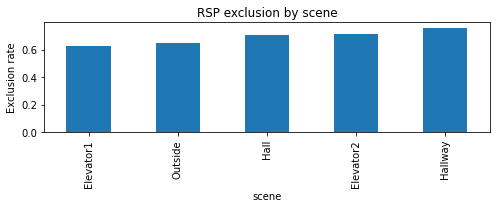

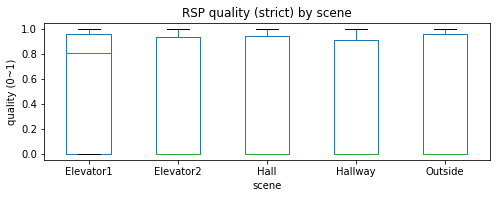

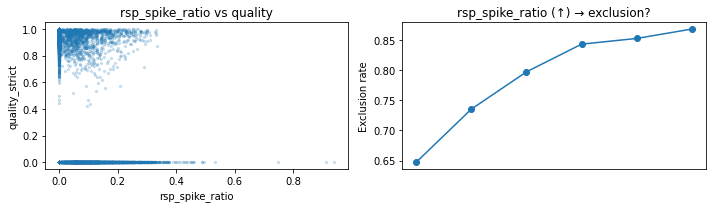

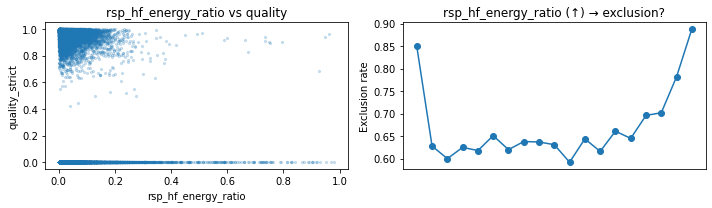

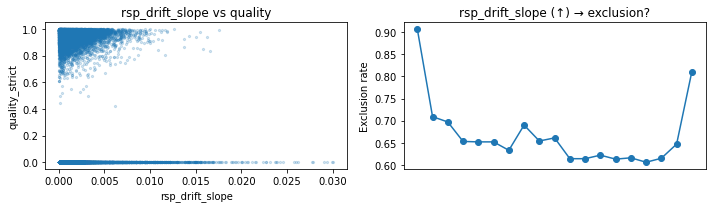

                     rsp_quality_strict  abnormal_rsp_ratio  cv_interval  \
rsp_quality_strict                 1.00               -0.05        -0.07   
abnormal_rsp_ratio                -0.05                1.00         0.22   
cv_interval                       -0.07                0.22         1.00   
cv_amplitude                       0.49                0.12         0.14   
rsp_spike_ratio                   -0.23               -0.00        -0.03   
rsp_hf_energy_ratio               -0.11                0.15         0.06   
rsp_drift_slope                   -0.05               -0.11        -0.07   

                     cv_amplitude  rsp_spike_ratio  rsp_hf_energy_ratio  \
rsp_quality_strict           0.49            -0.23                -0.11   
abnormal_rsp_ratio           0.12            -0.00                 0.15   
cv_interval                  0.14            -0.03                 0.06   
cv_amplitude                 1.00            -0.09                 0.04   
rsp_spike_ratio 

In [9]:
# (A1-1) Scene별 제외율 막대그래프
excl_by_scene = ws.groupby("scene")["exclude_flag_rsp"].mean().sort_values()
ax = excl_by_scene.plot(kind="bar", figsize=(7,3))
ax.set_ylabel("Exclusion rate")
ax.set_title("RSP exclusion by scene")
savefig("A1_exclusion_by_scene")

# (A1-2) Scene별 품질 분포(바이올린 또는 박스)
fig, ax = plt.subplots(figsize=(7,3))
ws.boxplot(column="rsp_quality_strict", by="scene", ax=ax, grid=False)
ax.set_title("RSP quality (strict) by scene")
ax.set_ylabel("quality (0~1)")
plt.suptitle("")
savefig("A1_quality_by_scene")

# (A1-3) 모션 proxy vs 품질/제외 (있을 때만)
if has_proxy:
    # 산점 + 러닝 평균 곡선(간단히 binning)
    for proxy in ["rsp_spike_ratio","rsp_hf_energy_ratio","rsp_drift_slope"]:
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        sample = ws[[proxy,"rsp_quality_strict","exclude_flag_rsp"]].dropna().sample(
            min(20000, ws.shape[0]), random_state=0
        )
        ax[0].scatter(sample[proxy], sample["rsp_quality_strict"], s=5, alpha=0.2)
        ax[0].set_xlabel(proxy); ax[0].set_ylabel("quality_strict")
        ax[0].set_title(f"{proxy} vs quality")

        # proxy를 20분위로 나눠 exclude 평균
        q = pd.qcut(sample[proxy], q=20, duplicates="drop")
        ax[1].plot(sample.groupby(q)["exclude_flag_rsp"].mean().values, marker="o")
        ax[1].set_xticks([])
        ax[1].set_ylabel("Exclusion rate")
        ax[1].set_title(f"{proxy} (↑) → exclusion?")
        savefig(f"A1_proxy_{proxy}")
else:
    print("A1 proxy plots skipped (no rsp_* proxy columns found).")

# (A1-4) 기본 상관표 (proxy가 있으면 포함)
corr_cols = ["rsp_quality_strict","abnormal_rsp_ratio","cv_interval","cv_amplitude"]
if has_proxy: corr_cols += ["rsp_spike_ratio","rsp_hf_energy_ratio","rsp_drift_slope"]
corr = ws[corr_cols].corr().round(2)
print(corr)


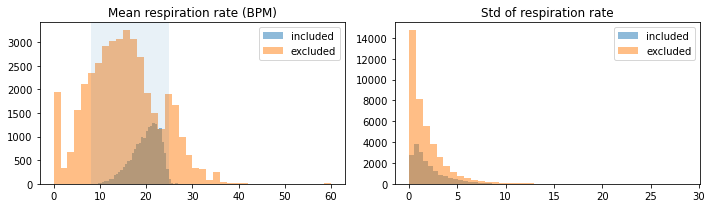

,metric,included_mean,excluded_mean,included_n,excluded_n
0,rsp_quality_strict,0.949537,0.152018,18586,40504
1,abnormal_rsp_ratio,0.064608,0.325304,18586,40504
2,y_mean_raw,4.399781,4.218048,18533,40280
3,y_delta_raw,0.492392,0.422659,18533,40280
4,cv_interval,0.001462,0.016374,18586,7866
5,cv_amplitude,0.099463,0.024073,18586,30014


In [10]:
inc = ws[ws["exclude_flag_rsp"]==False]
exc = ws[ws["exclude_flag_rsp"]==True]

# (A2-1) 호흡수 범위/분포 비교
fig, ax = plt.subplots(1,2, figsize=(10,3))
for s,lab,c in [(inc,"included",0),(exc,"excluded",1)]:
    ax[0].hist(s["mean_rsp_rate"].dropna(), bins=40, alpha=0.5, label=lab)
ax[0].axvspan(8,25, alpha=0.1)  # 정상범위 가이드
ax[0].set_title("Mean respiration rate (BPM)")
ax[0].legend()

ax[1].hist(inc["std_rsp_rate"].dropna(), bins=40, alpha=0.5, label="included")
ax[1].hist(exc["std_rsp_rate"].dropna(), bins=40, alpha=0.5, label="excluded")
ax[1].set_title("Std of respiration rate")
ax[1].legend()
savefig("A2_rate_distributions")

# (A2-2) 포함 vs 제외의 품질/라벨 차이 요약
def summary_t(series, name):
    s1 = inc[series].dropna(); s2 = exc[series].dropna()
    return {
        "metric": name,
        "included_mean": s1.mean(),
        "excluded_mean": s2.mean(),
        "included_n": s1.size,
        "excluded_n": s2.size
    }

rows = []
for col in ["rsp_quality_strict","abnormal_rsp_ratio","y_mean_raw","y_delta_raw","cv_interval","cv_amplitude"]:
    if col in ws.columns:
        rows.append(summary_t(col, col))
pd.DataFrame(rows)


In [11]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# 피처 구성 (있으면 쓰고, 없으면 빠짐)
feat_rsp = [c for c in ["mean_rsp_rate","cv_interval","cv_amplitude",
                        "rsp_spike_ratio","rsp_hf_energy_ratio","rsp_drift_slope"]
            if c in ws.columns]
feat_base = []  # 여기선 순수 RSP 유틸만 보려면 공백으로 두는 게 깔끔

def cv_eval(df, features, ycol="y_mean_raw", n_split=5, seed=0):
    df_ = df.dropna(subset=features+[ycol]).copy()
    if df_.empty:
        return {"r2": np.nan, "mae": np.nan, "n": 0}
    X = df_[features].to_numpy()
    y = df_[ycol].to_numpy()
    kf = KFold(n_splits=n_split, shuffle=True, random_state=seed)
    r2s, maes = [], []
    for tr, te in kf.split(X):
        ss = StandardScaler()
        Xtr = ss.fit_transform(X[tr]); Xte = ss.transform(X[te])
        model = Ridge(alpha=1.0).fit(Xtr, y[tr])
        pred = model.predict(Xte)
        r2s.append(r2_score(y[te], pred))
        maes.append(mean_absolute_error(y[te], pred))
    return {"r2": float(np.mean(r2s)), "mae": float(np.mean(maes)), "n": int(len(y))}

# 세 가지 세트 비교: 전체 / 포함만 / 제외된 창(참고)
sets = {
    "ALL": ws,
    "IncludedOnly": ws[ws["exclude_flag_rsp"]==False],
    "ExcludedOnly": ws[ws["exclude_flag_rsp"]==True],  # 참고용
}

rows = []
if feat_rsp:
    for k,df_ in sets.items():
        rows.append({"set": k, **cv_eval(df_, feat_rsp)})
else:
    print("No RSP features for A3 (skipped).")
res = pd.DataFrame(rows)
print(res)


            set        r2       mae      n
0           ALL  0.000506  2.203613  25114
1  IncludedOnly  0.000550  2.263000  18533
2  ExcludedOnly  0.001505  2.025789   6581


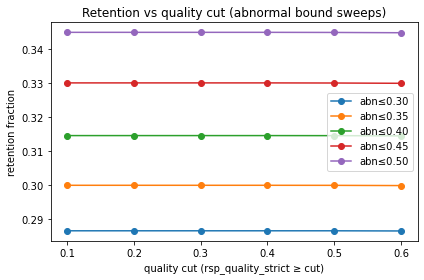

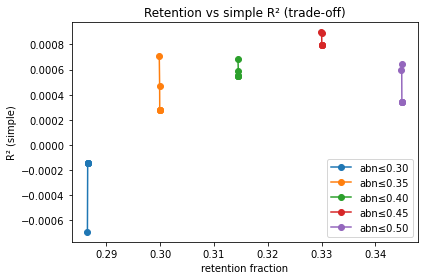

In [12]:
q_grid = np.linspace(0.1, 0.6, 6)   # quality cut (예: 0.1~0.6)
a_grid = [0.30, 0.35, 0.40, 0.45, 0.50]  # abnormal cut

def retention(df, qcut, acut):
    kept = df[(df["rsp_quality_strict"]>=qcut) & (df["abnormal_rsp_ratio"]<=acut)]
    return kept

rec = []
for qc in q_grid:
    for ac in a_grid:
        kept = retention(ws, qc, ac)
        frac = len(kept) / max(1,len(ws))
        mean_q = kept["rsp_quality_strict"].mean() if not kept.empty else np.nan
        # 아주 가벼운 예측 성능 (있으면만)
        if feat_rsp and not kept.empty:
            ev = cv_eval(kept, feat_rsp)
            rec.append({"qcut":qc, "acut":ac, "retention":frac, "mean_quality":mean_q,
                        "r2":ev["r2"], "mae":ev["mae"]})
        else:
            rec.append({"qcut":qc, "acut":ac, "retention":frac, "mean_quality":mean_q,
                        "r2":np.nan, "mae":np.nan})
sweep = pd.DataFrame(rec)

# (A4-1) 보존율 vs 품질
fig, ax = plt.subplots(figsize=(6,4))
for ac in a_grid:
    sub = sweep[sweep["acut"]==ac]
    ax.plot(sub["qcut"], sub["retention"], marker="o", label=f"abn≤{ac:.2f}")
ax.set_xlabel("quality cut (rsp_quality_strict ≥ cut)")
ax.set_ylabel("retention fraction")
ax.set_title("Retention vs quality cut (abnormal bound sweeps)")
ax.legend()
savefig("A4_retention_vs_quality")

# (A4-2) 보존율 vs 간단 R² (있을 때만)
if "r2" in sweep.columns and sweep["r2"].notna().any():
    fig, ax = plt.subplots(figsize=(6,4))
    for ac in a_grid:
        sub = sweep[sweep["acut"]==ac]
        ax.plot(sub["retention"], sub["r2"], marker="o", label=f"abn≤{ac:.2f}")
    ax.set_xlabel("retention fraction")
    ax.set_ylabel("R² (simple)")
    ax.set_title("Retention vs simple R² (trade-off)")
    ax.legend()
    savefig("A4_retention_vs_r2")
else:
    print("A4 R² plot skipped (no RSP features or empty).")


               n      k   rate  ci_low  ci_high
scene                                          
Elevator1  11889   7489  0.630   0.621    0.639
Outside    18410  11952  0.649   0.642    0.656
Hall        6186   4360  0.705   0.693    0.716
Elevator2  10302   7351  0.714   0.705    0.722
Hallway    12303   9352  0.760   0.753    0.768


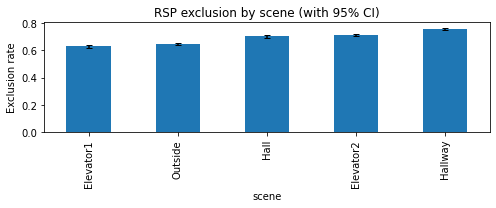

                               GEE Regression Results                              
Dep. Variable:            exclude_flag_rsp   No. Observations:                59090
Model:                                 GEE   No. clusters:                      108
Method:                        Generalized   Min. cluster size:                 254
                      Estimating Equations   Max. cluster size:                1537
Family:                           Binomial   Mean cluster size:               547.1
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Mon, 20 Oct 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         16:08:14
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5348      0.076      7.054      0.00

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import statsmodels.api as sm
import statsmodels.formula.api as smf

ws = pd.read_parquet("./ml_processed_all/window_summaries.parquet")

# 1) 장면별 단순 요약 (제외율 + 95% CI, 윈도 수)
g = ws.groupby("scene")
counts = g["exclude_flag_rsp"].agg(n="count", k="sum")  # k=excluded windows
counts["rate"] = counts["k"] / counts["n"]

# Wilson 95% CI
low, high = proportion_confint(counts["k"], counts["n"], method="wilson")
counts["ci_low"]  = low
counts["ci_high"] = high
counts = counts.sort_values("rate")
print(counts[["n","k","rate","ci_low","ci_high"]].round(3))

# 시각화(오차막대 포함)
ax = counts["rate"].plot(kind="bar", yerr=[counts["rate"]-counts["ci_low"], 
                                           counts["ci_high"]-counts["rate"]],
                         capsize=3, figsize=(7,3))
ax.set_ylabel("Exclusion rate")
ax.set_title("RSP exclusion by scene (with 95% CI)")
plt.tight_layout()
plt.show()

# 2) 개인-고정 효과: GEE(이항, 군집=pid)로 scene 효과 검정
# - exclude_flag_rsp ~ C(scene), 군집: pid
df = ws.dropna(subset=["exclude_flag_rsp","pid","scene"]).copy()
df["exclude_flag_rsp"] = df["exclude_flag_rsp"].astype(int)
# 기준(baseline) 씬을 Elevator1로 두고 싶으면 카테고리 순서 지정
if "Elevator1" in df["scene"].unique():
    df["scene"] = pd.Categorical(df["scene"], 
                                 categories=["Elevator1"] + [s for s in df["scene"].unique() if s!="Elevator1"],
                                 ordered=True)

model = smf.gee("exclude_flag_rsp ~ C(scene)", groups="pid",
                data=df, family=sm.families.Binomial(), cov_struct=sm.cov_struct.Exchangeable())
res = model.fit()
print(res.summary())

# → 요약 해석:
#   - 각 C(scene)[T.x]의 추정치는 Elevator1 대비 로그오즈(log-odds) 차이
#   - exp(coef)하면 오즈비(OR). 1보다 크면 "제외 가능성이 더 큼"
or_table = np.exp(res.params)
conf_int = res.conf_int()
or_ci = np.exp(conf_int)
out = pd.DataFrame({"OR": or_table, "OR_low": or_ci[0], "OR_high": or_ci[1], "p": res.pvalues})
print(out.round(3))
